# Import Dependacies

In [ ]:
!pip install pydicom

In [ ]:
!git clone https://github.com/Bhuribhat/PET-CT-Scan.git

In [3]:
import os
import cv2
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as tf
import torchvision.models.segmentation
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device}")

Using cuda


# Data Transform and Helper Function


In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Resize((120, 120), antialias=True),
     transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]), 
])

transform_mask = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((120, 120), antialias=True),
])

batch_size = 32

In [11]:
def getLabel(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask1 = cv2.inRange(hsv, (0,128,128), (5,255,255))
    mask2 = cv2.inRange(hsv, (175,128,128), (180,255,255))
    mask3 = cv2.bitwise_or(mask1, mask2)

    label = mask3.astype(np.float32) / 255.0
    label[label > 0.5] = 1.0
    label[label <= 0.5] = 0.0
    label = torch.from_numpy(label)
    return label


# Define the IoU calculation function
def calculate_iou(pred_mask, true_mask):
    pred_mask[pred_mask >  0.5] = 1.0
    pred_mask[pred_mask <= 0.5] = 0.0

    pred_mask = np.array(pred_mask)
    true_mask = np.array(true_mask)

    intersection = np.logical_and(pred_mask, true_mask)
    union = np.logical_or(pred_mask, true_mask)

    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score


class DCMDataSet(Dataset):
    def __init__(self, dcm_dir, transform, transform_mask):
        self.dcm_dir = dcm_dir
        self.dcm_files = list()
        self.transforms = transform
        self.transform_mask = transform_mask

        for patient in os.listdir(dcm_dir):
          if (patient == '.DS_Store'):
            continue

          label = 'nolabel'
          if (patient == 'Patient21'):
            continue
          for name in os.listdir(os.path.join(dcm_dir,patient,label)):
            if (name == '.DS_Store'):
              continue

            file_len = os.listdir(os.path.join(dcm_dir,patient, label, name))
            file_len = len(file_len)

            for fileName in os.listdir(os.path.join(dcm_dir,patient, label, name)):
              if (fileName == '.DS_Store'):
                continue

              file_path = os.path.join(dcm_dir, patient, label,name, fileName)
              labelnumfile = (int)((fileName.split("-")[2])[0:4])

              if (labelnumfile > file_len):
                labelnumfile -= file_len
    
              labelnumfile = (str)(labelnumfile)
              labelnumfile_len = len(labelnumfile)
              labelnumfile = ("0" * (4 - labelnumfile_len)) + labelnumfile
              labelfilename = fileName.split("-")[0:2]
              labelfilename = labelfilename[0] + "-" + labelfilename[1] + "-" + labelnumfile + ".dcm"
              label_filepath = os.path.join(dcm_dir,patient,"label",name,labelfilename)
              labelfile=pydicom.dcmread(label_filepath).pixel_array

              # tlfile = transform_mask(labelfile)
              mask = getLabel(labelfile)
              self.dcm_files.append([file_path,mask]);
    
    def __len__(self):
        return len(self.dcm_files)
    
    def __getitem__(self, idx):
        image = pydicom.dcmread(self.dcm_files[idx][0]).pixel_array
        image = self.transforms(image)
        masks = self.dcm_files[idx][1]
        masks = np.array(masks)
        masks = self.transform_mask(masks)
        
        # Return the preprocessed DCM data and its corresponding label (if applicable)
        return image, masks

In [12]:
# Create an instance of the custom DCM dataset
dataset = DCMDataSet(dcm_dir='/content/Segment/DicomData', transform=transform, transform_mask=transform_mask)
trainsize = (int)(0.8 * dataset.__len__())
trainset, valset = torch.utils.data.random_split(dataset, [trainsize, dataset.__len__() - trainsize])

# Create a DataLoader to iterate over the dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=True)

# Create Model

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.max_pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x):
        x = self.max_pool(x)
        x = self.conv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        self.bilinear = bilinear
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        if self.bilinear:
            x1 = self.up(x1)
        else:
            x1 = self.up(x1, output_size=x2.size())
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super().__init__()
        self.bilinear = bilinear
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [13]:
# Pretrained Model
Net = torchvision.models.segmentation.deeplabv3_resnet50(weights=True)

# Change final layer to 3 classes
Net.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1)) 
Net = Net.to(device)

# Create adam optimizer
optimizer = torch.optim.Adam(params=Net.parameters(), lr=0.0002)

# Define your loss function
criterion = torch.nn.CrossEntropyLoss()

# Train Model

In [ ]:
# Training loop
num_epochs = 5
best_iou = 0.0
best_loss = float('inf')

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}\n" + "-" * 30)
    running_loss = 0.0
    total_iou = 0.0

    # Training phase
    Net.train()
    with torch.set_grad_enabled(True):
        for images, labels in trainloader:
            images = images.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            outputs = Net(images)

            # Forward pass
            predictions = outputs['out']
            predictions[predictions > 0.5] = 1.0
            predictions[predictions <= 0.5] = 0.0

            # Calculate loss
            loss = criterion(predictions, labels)
            running_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate IoU
            iou_scores = []
            for i in range(len(predictions)):
                pred_mask = predictions[i].argmax(dim=0).cpu().numpy()
                true_mask = labels[i].cpu().numpy()
                iou = calculate_iou(pred_mask, true_mask)
                iou_scores.append(iou)

            batch_iou = np.mean(iou_scores)
            total_iou += batch_iou

    epoch_loss = running_loss / len(trainloader)
    epoch_iou = total_iou / len(trainloader)
    print(f'Training Loss: {epoch_loss:.4f}\nTraining IoU: {epoch_iou:.4f}')


    # Validation phase
    Net.eval()
    total_val_loss = 0.0
    total_val_iou = 0.0

    with torch.no_grad():
        for images_val, labels_val in valloader:
            images_val = images_val.to(device)
            labels_val = labels_val.to(device)

            outputs_val = Net(images_val)
            predictions_val = outputs_val['out']
            predictions_val[predictions_val >  0.5] = 1.0
            predictions_val[predictions_val <= 0.5] = 0.0

            loss_val = criterion(predictions_val, labels_val)
            total_val_loss += loss_val.item()

            iou_scores_val = []
            for i in range(len(predictions_val)):
                pred_mask_val = predictions_val[i].argmax(dim=0).cpu().numpy()
                true_mask_val = labels_val[i].cpu().numpy()
                iou_val = calculate_iou(pred_mask_val, true_mask_val)
                iou_scores_val.append(iou_val)

            batch_iou_val = np.mean(iou_scores_val)
            total_val_iou += batch_iou_val

    val_loss = total_val_loss / len(valloader)
    val_iou = total_val_iou / len(valloader)

    best_loss = min(best_loss, val_loss)
    print(f'Validation Loss: {val_loss:.4f}\nValidation IoU: {val_iou:.4f}\n')

    # Check if current validation IoU is the best and save the model
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(Net.state_dict(), 'model.pth')
        print(f"Model saved successfully at IoU = {best_iou}\n")


print("Finished Training!")
print(f"Best IoU: {best_iou:.4f}")
print(f"Minimum Training Loss: {best_loss:.4f}")

# Model Evaluation

In [ ]:
# Load Model
PATH ='/content/model_state.pth'
Net.load_state_dict(torch.load(PATH))
Net.to(device)

Image: 1


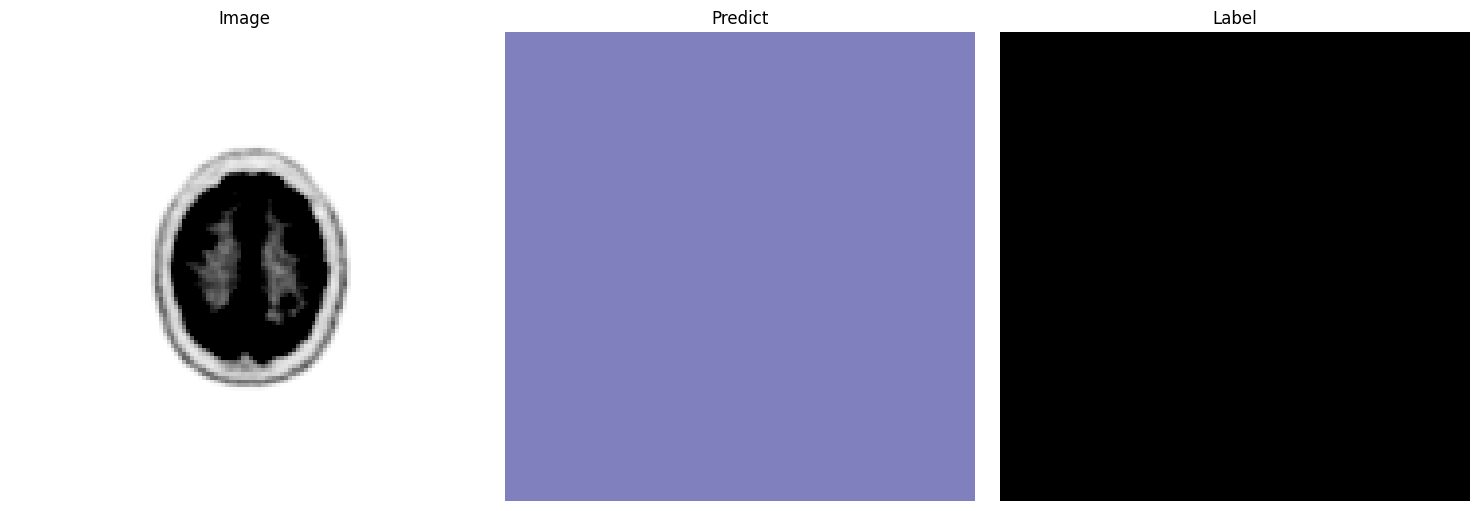

Image: 2


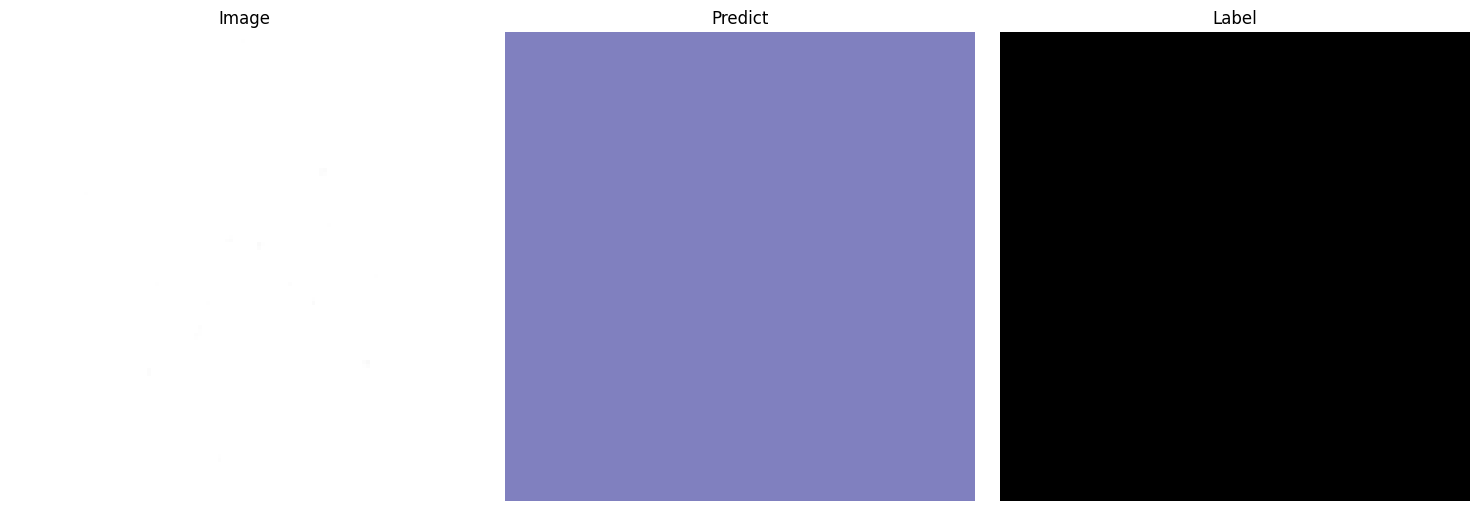

Image: 3


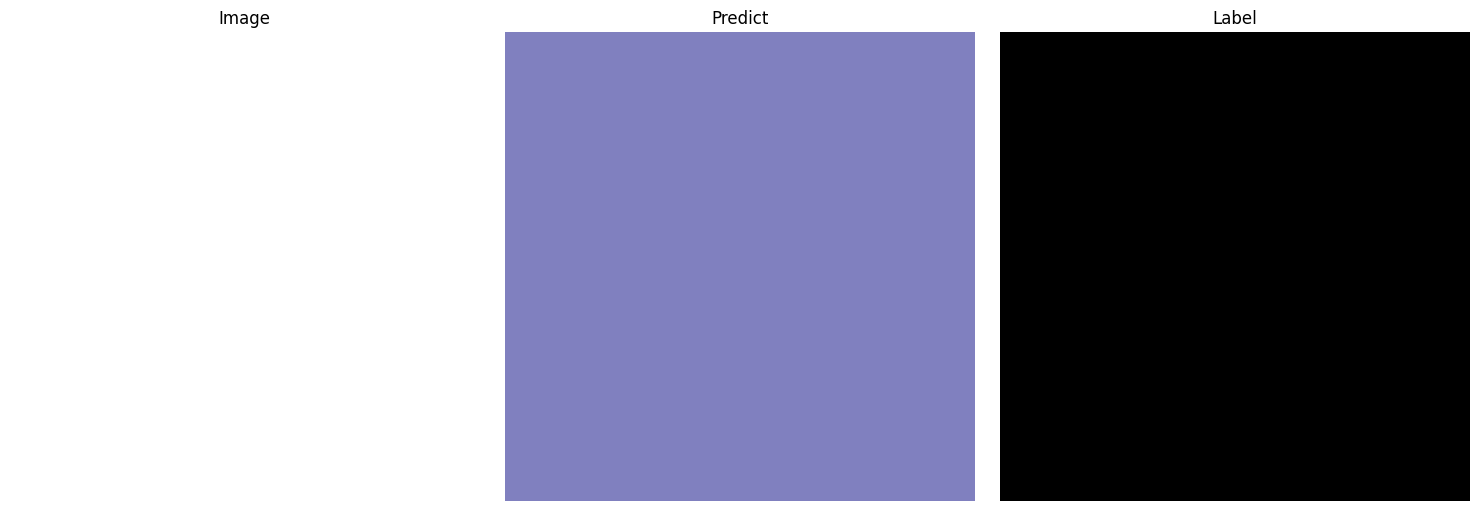

Image: 4


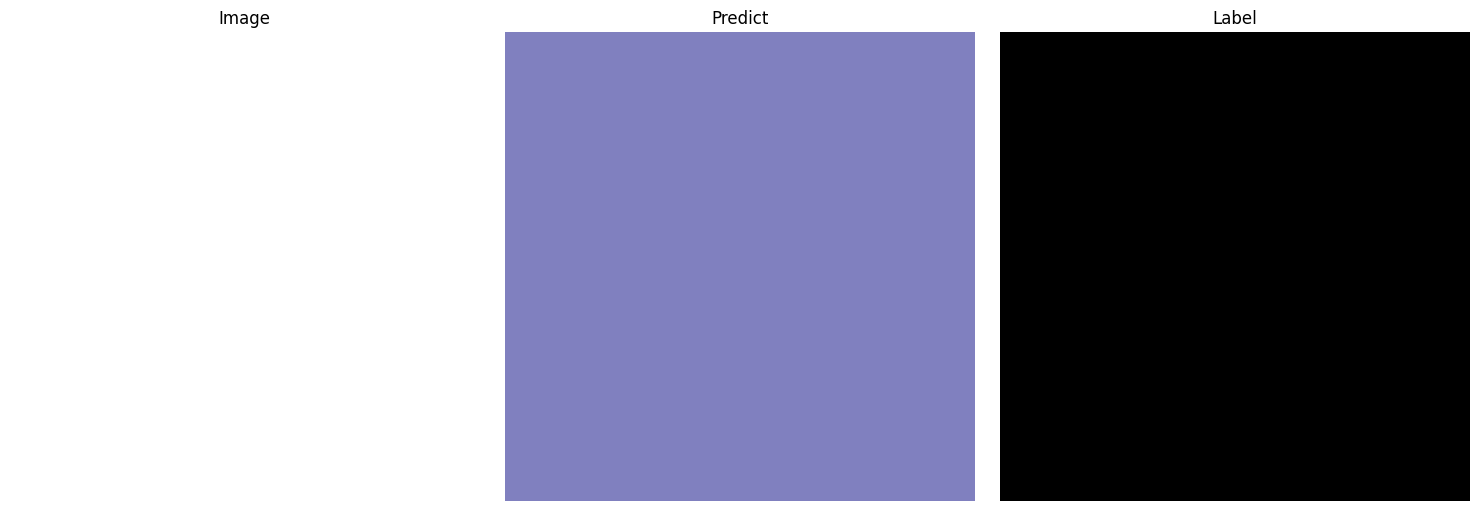

Image: 5


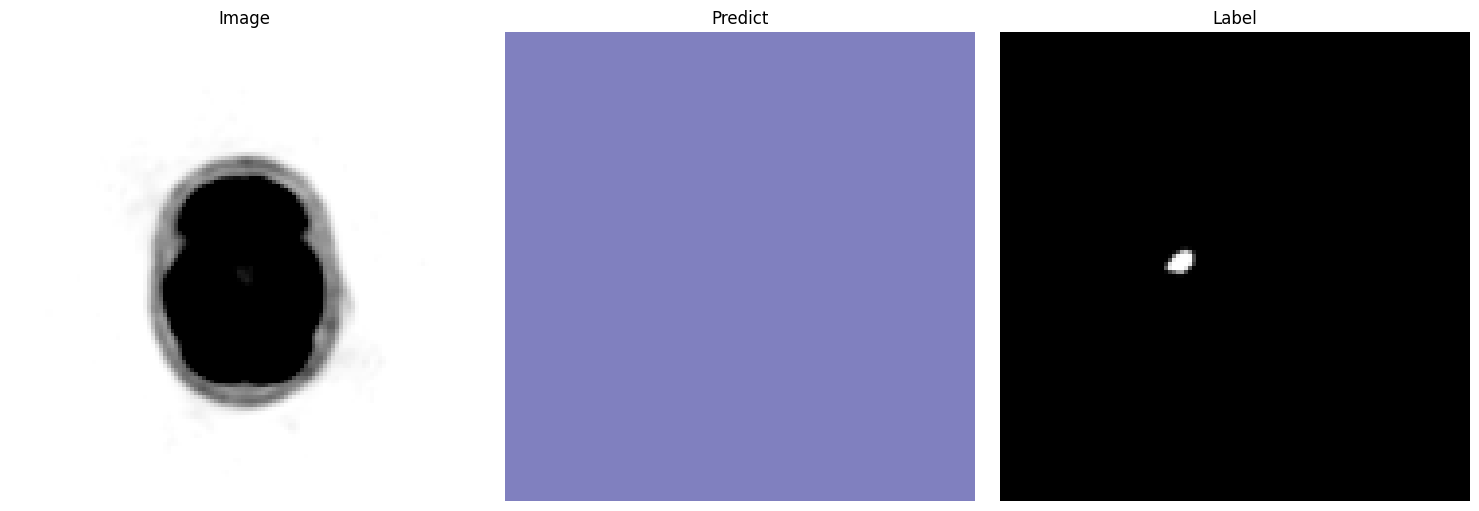

Image: 6


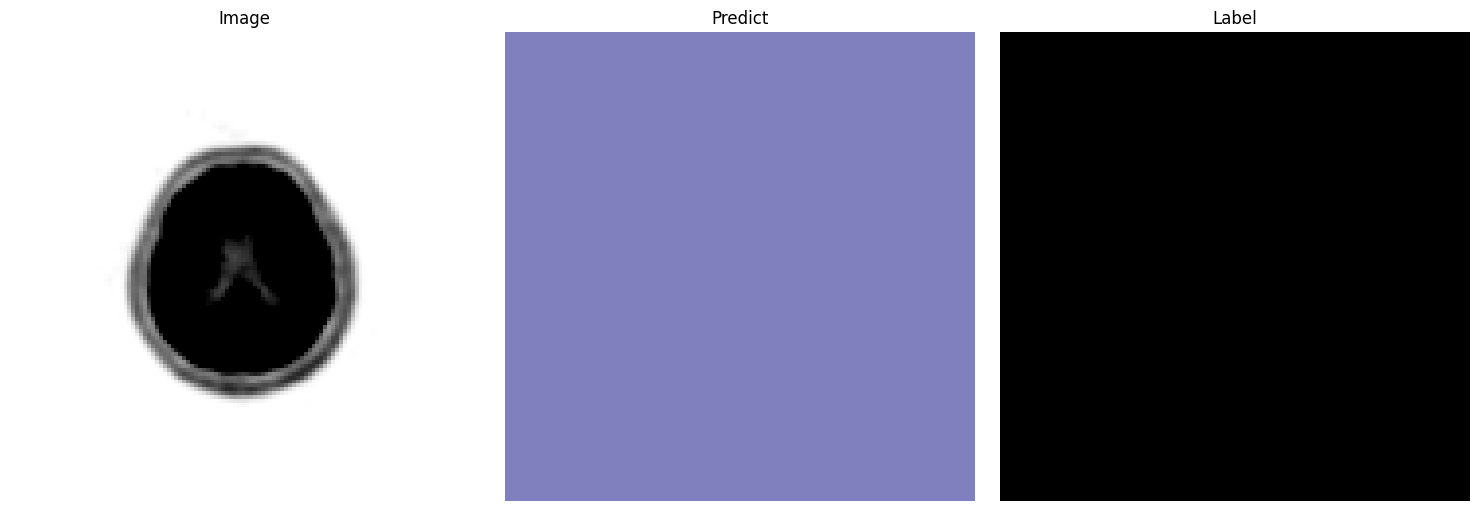

Image: 7


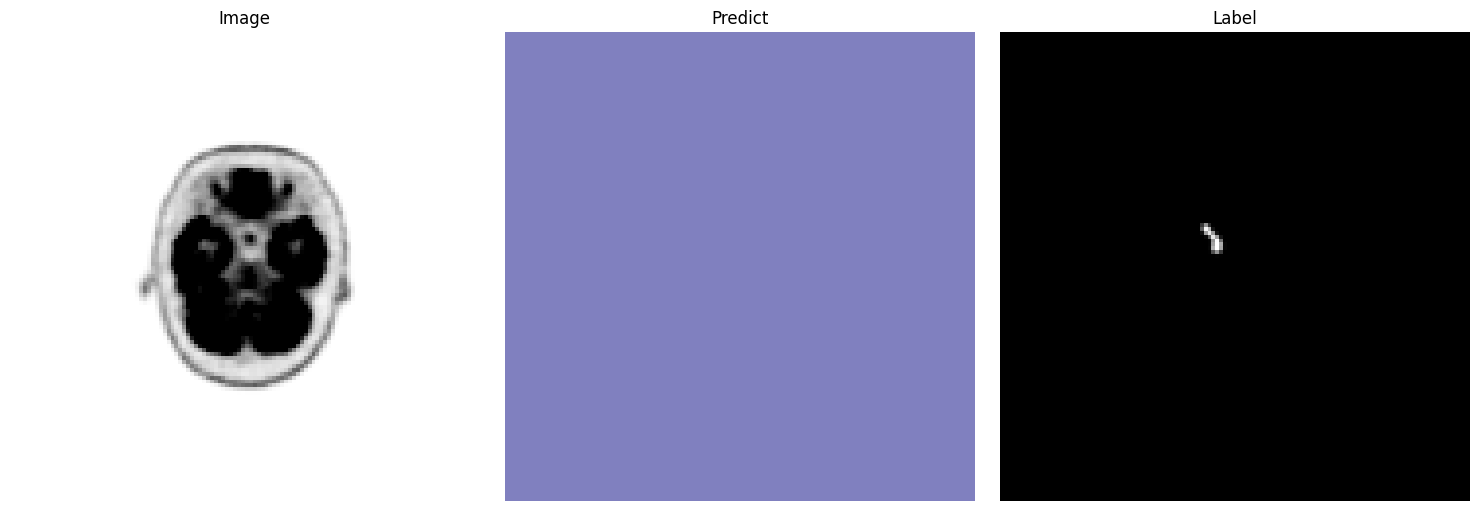

Image: 8


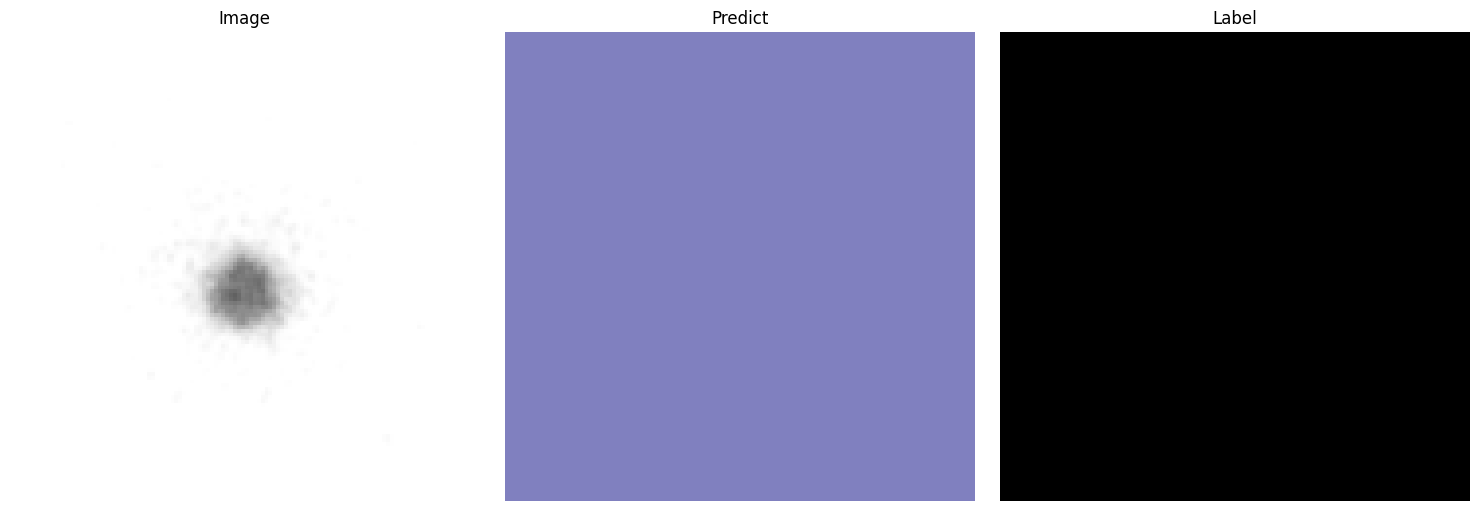

Image: 9


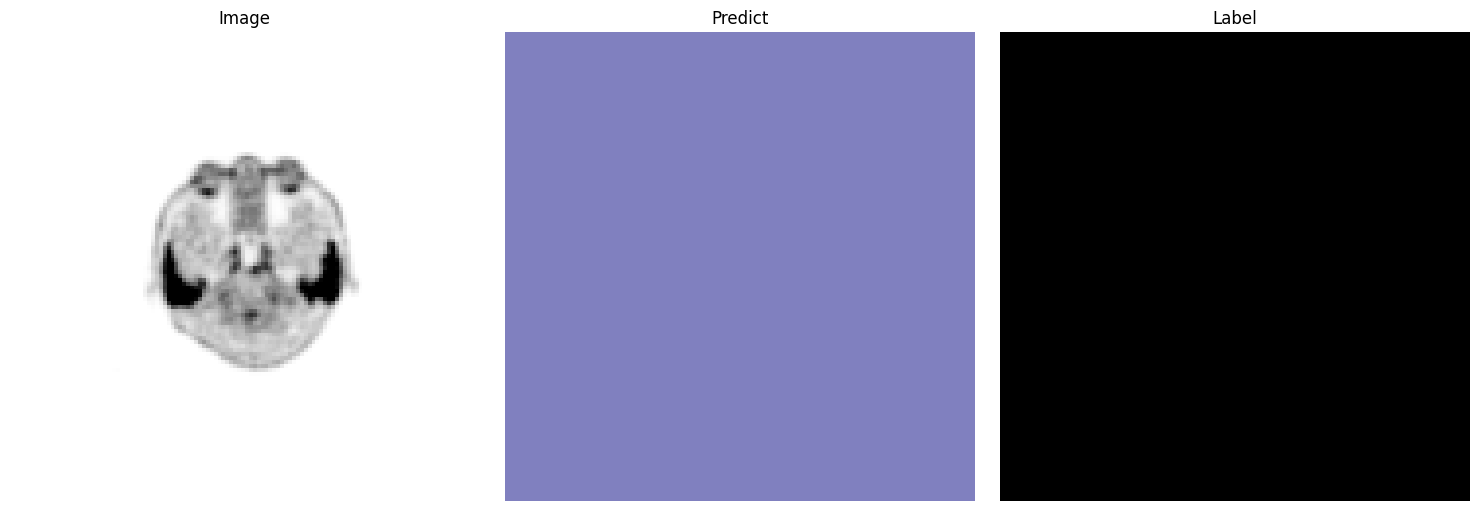

Image: 10


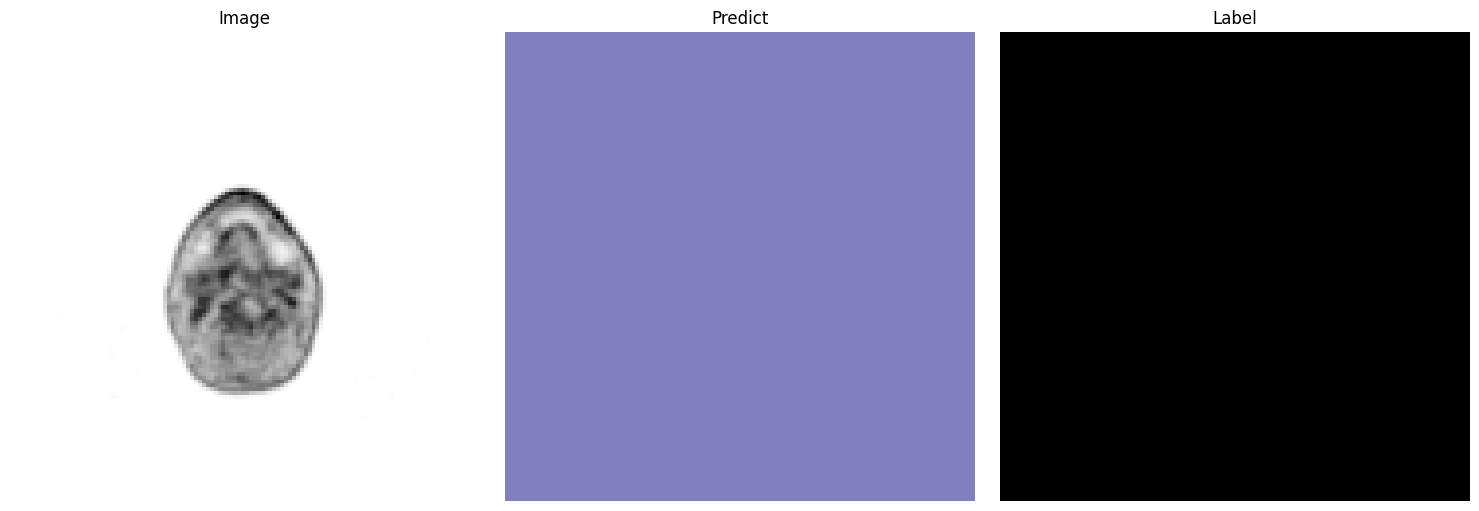

Image: 11


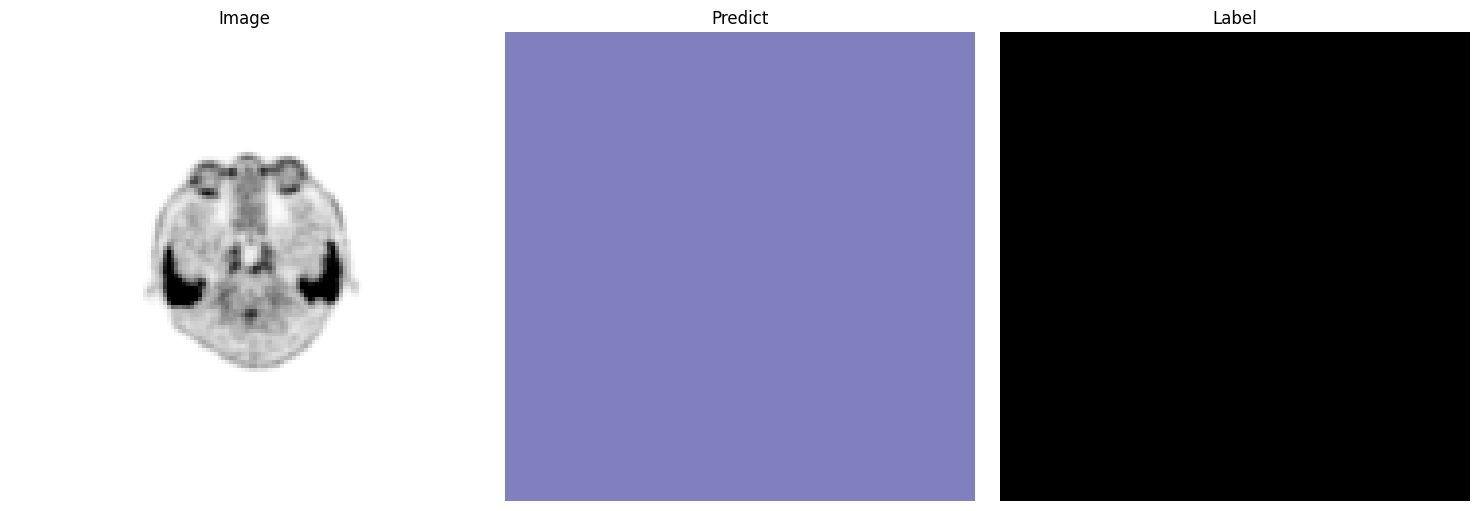

Image: 12


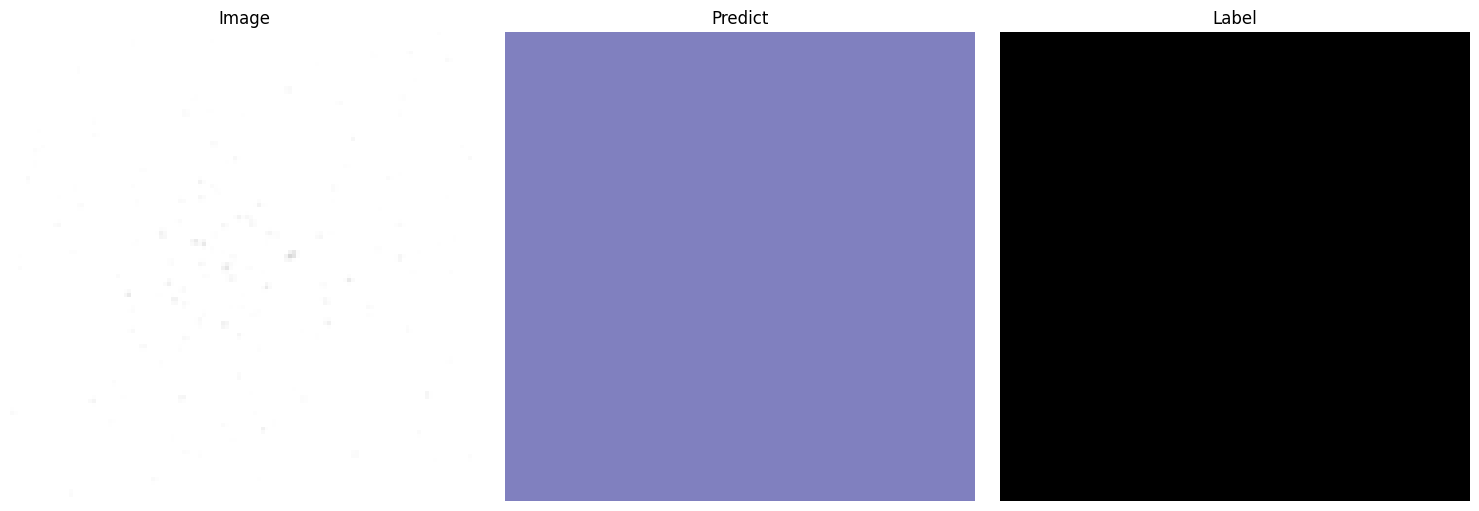

Image: 13


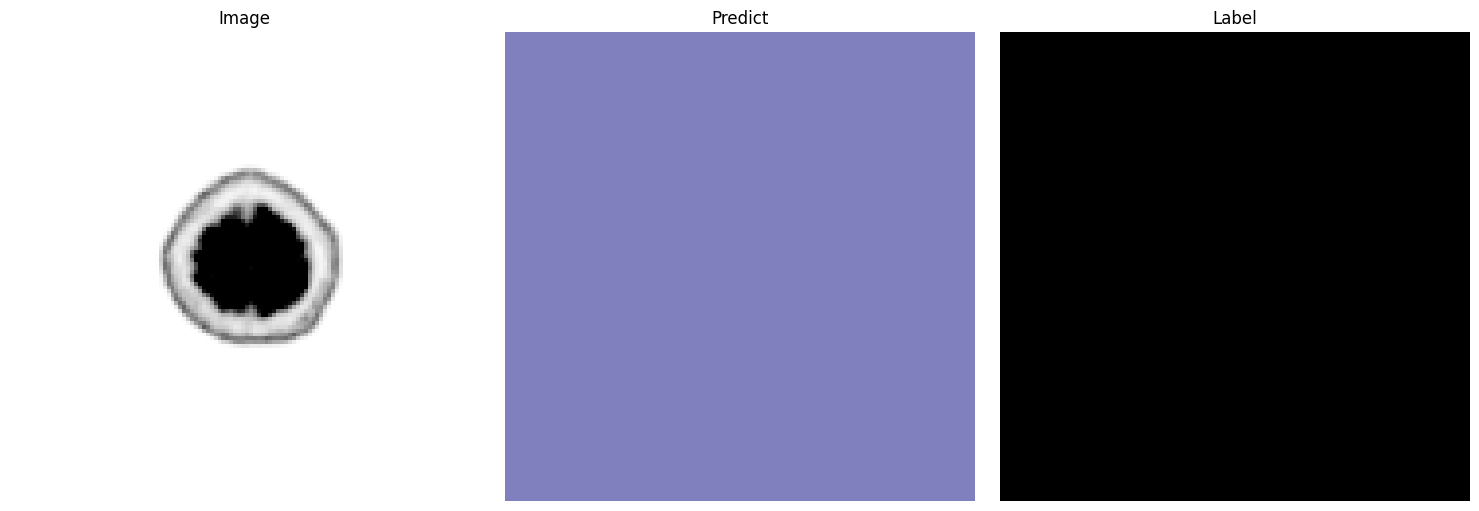

Image: 14


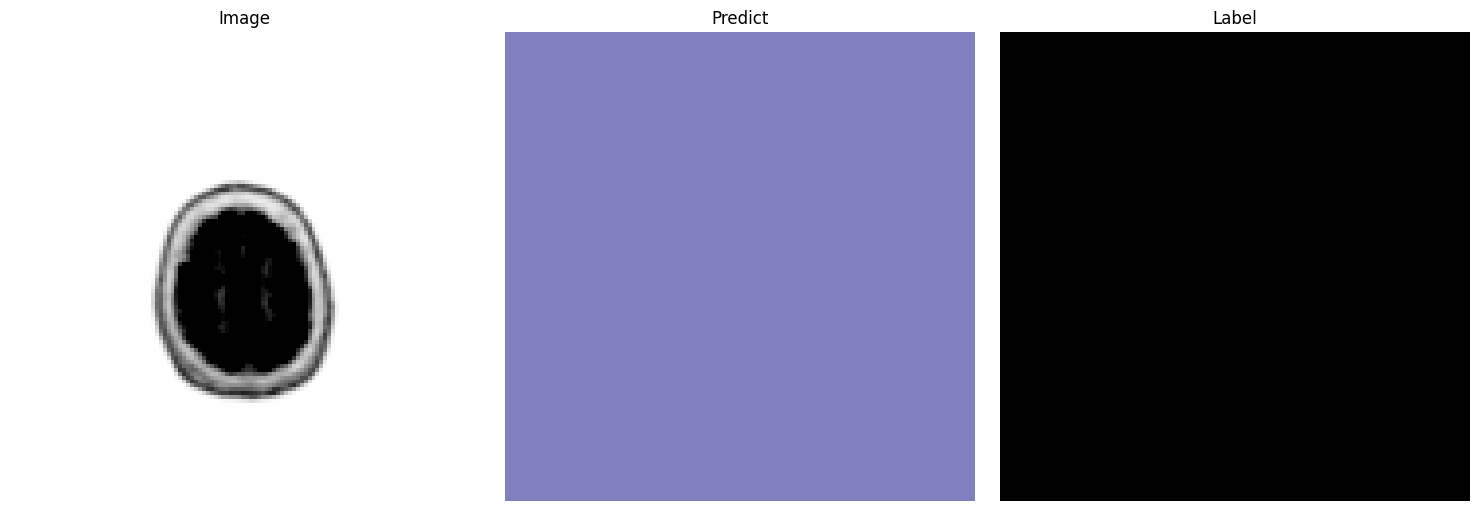

Image: 15


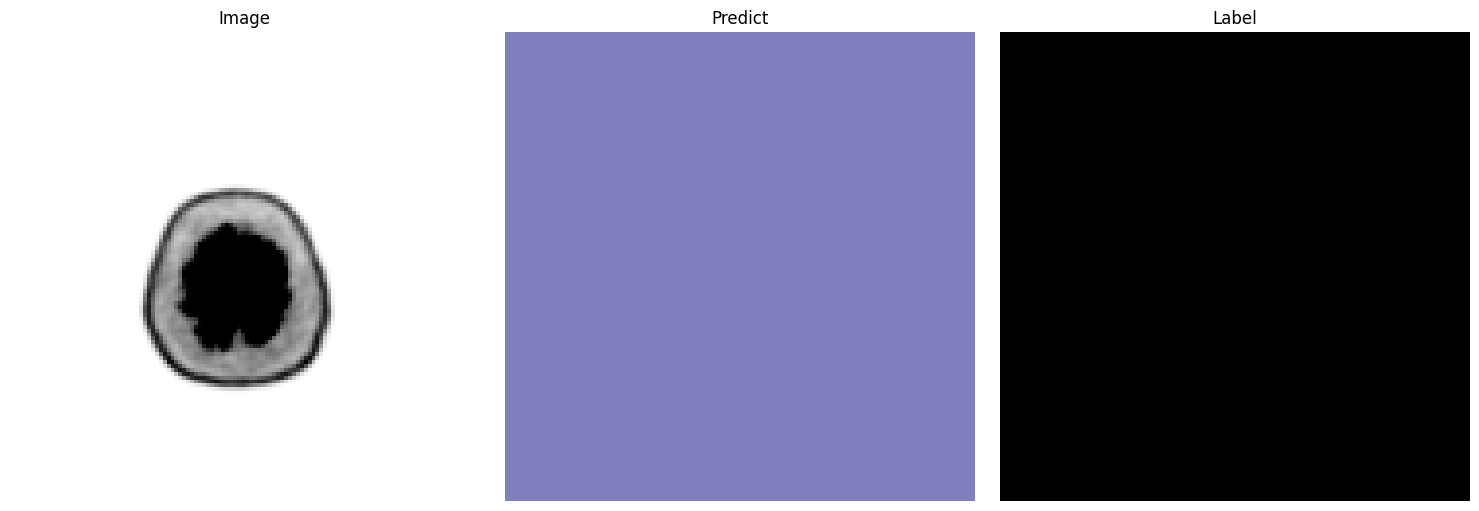

Image: 16


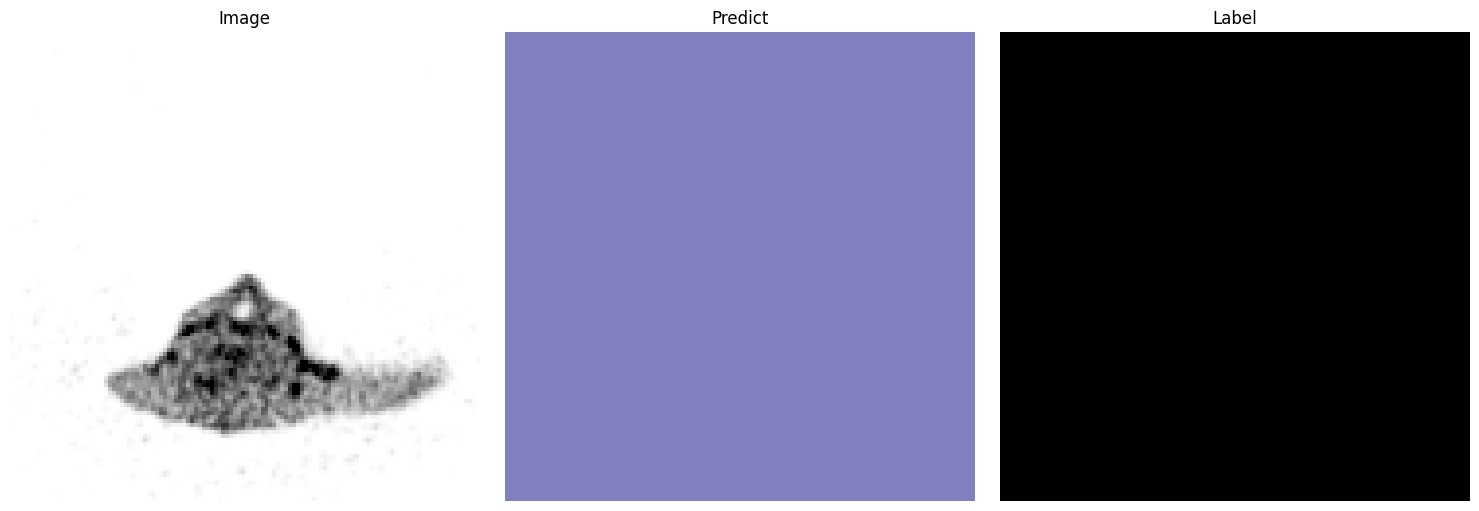

Image: 17


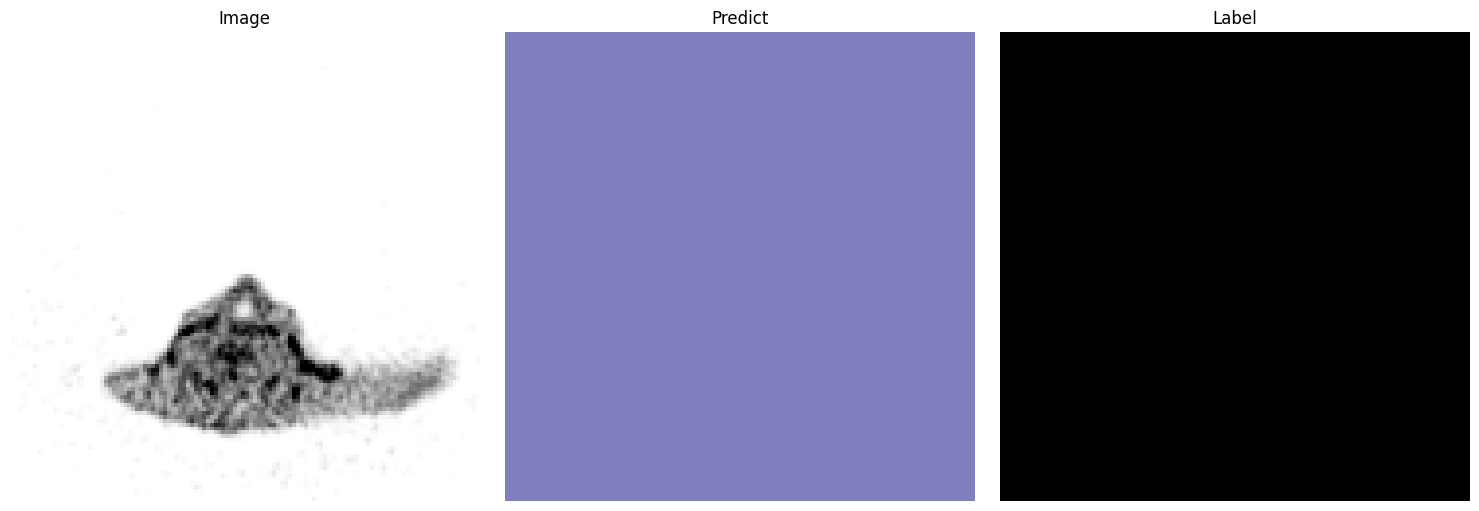

Image: 18


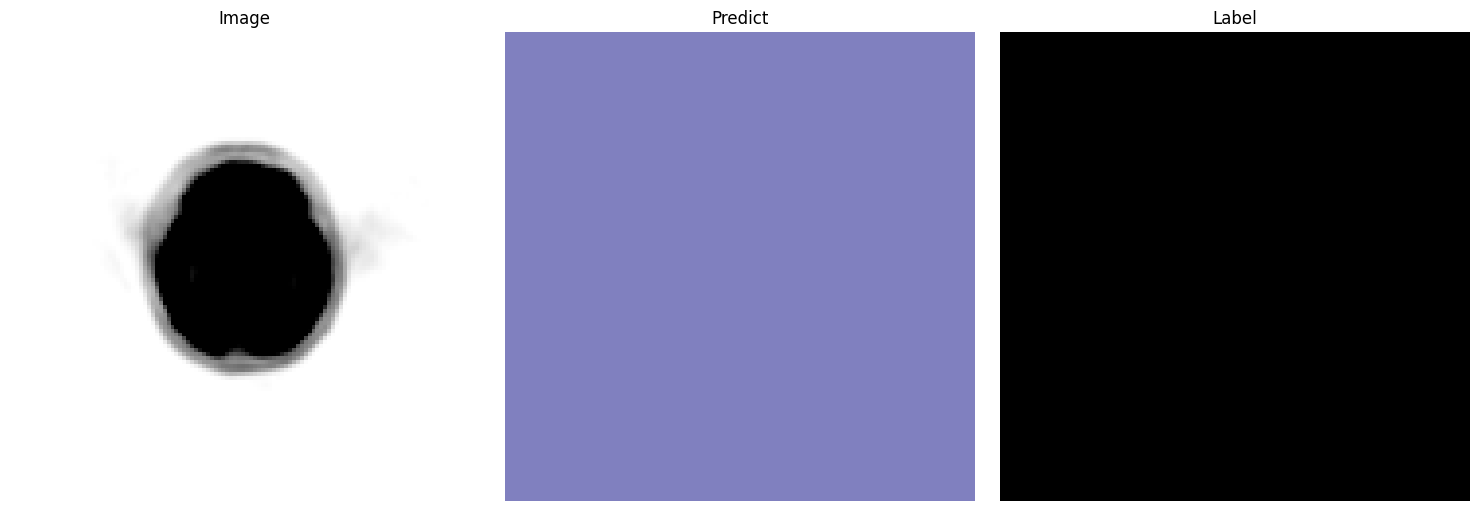

Image: 19


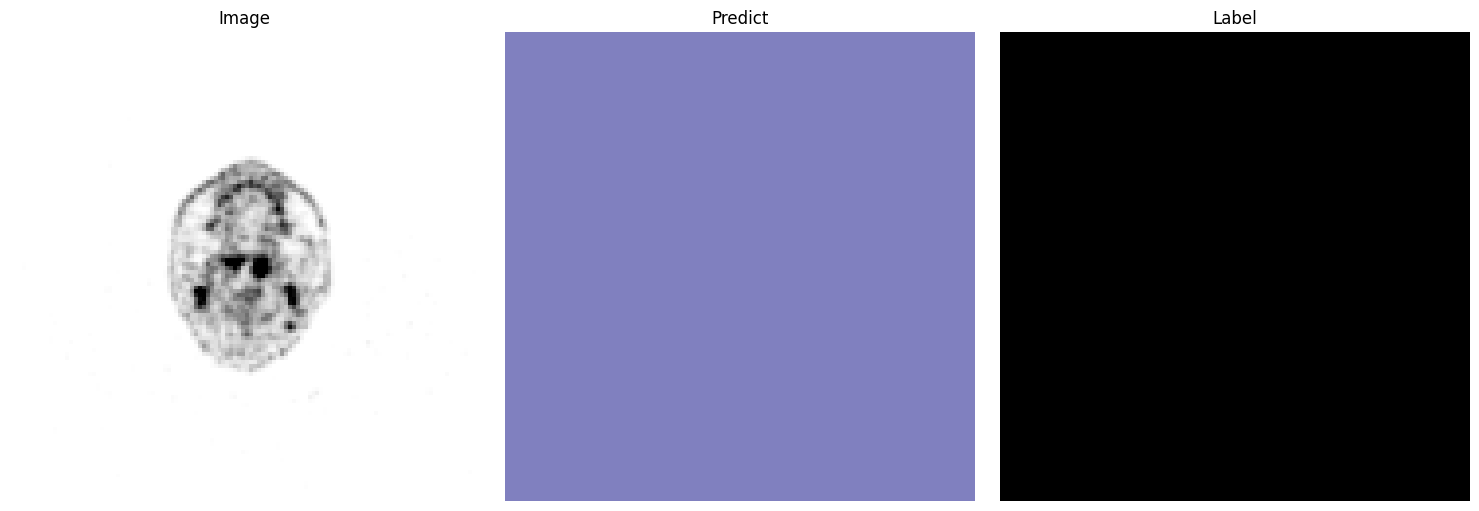

Image: 20


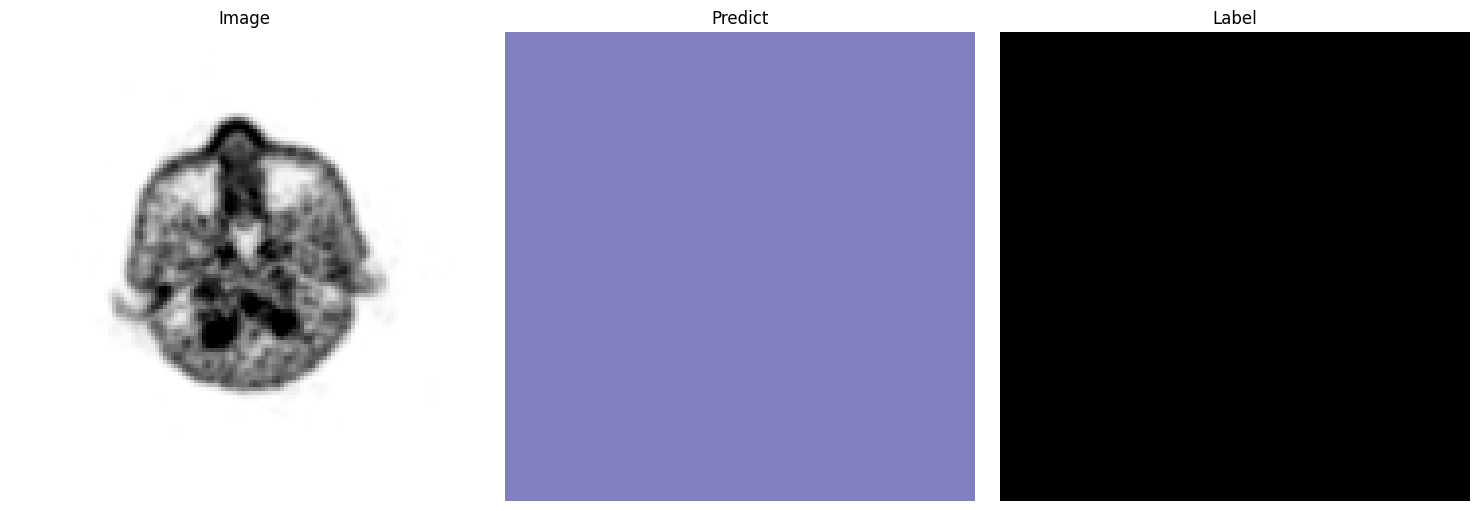

Image: 21


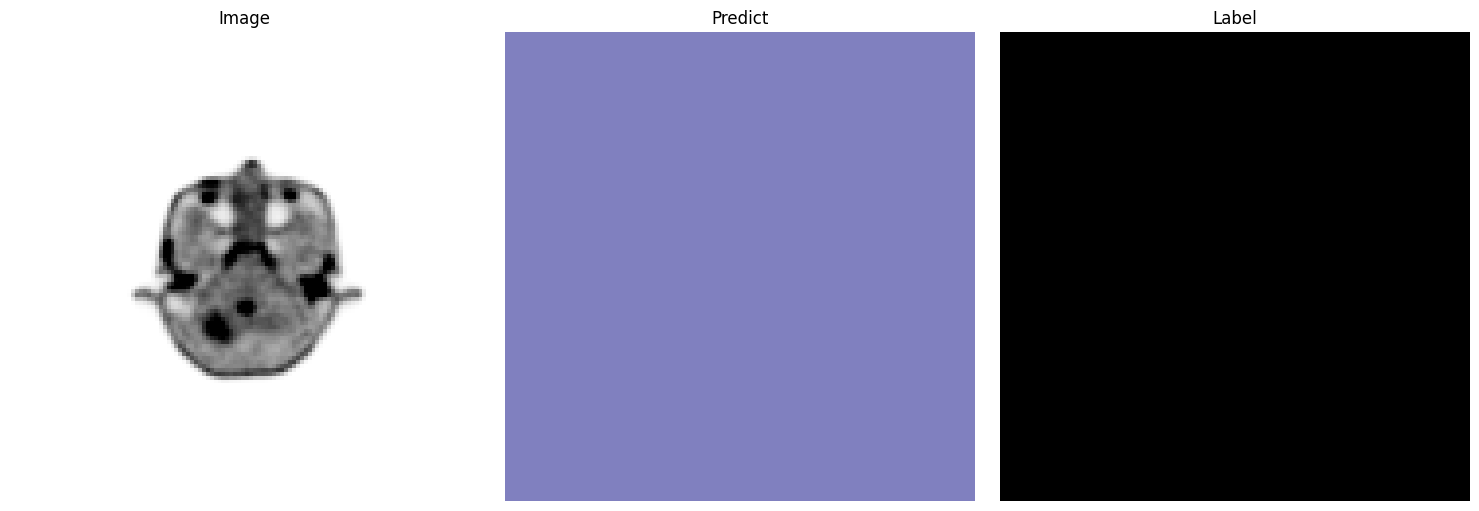

Image: 22


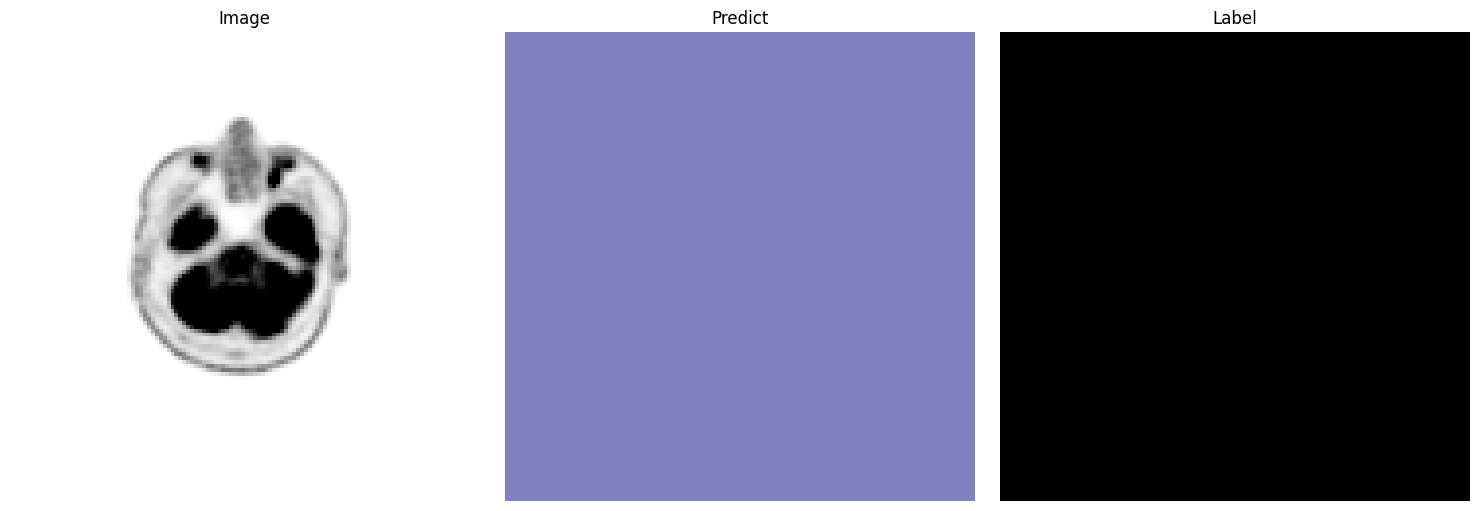

Image: 23


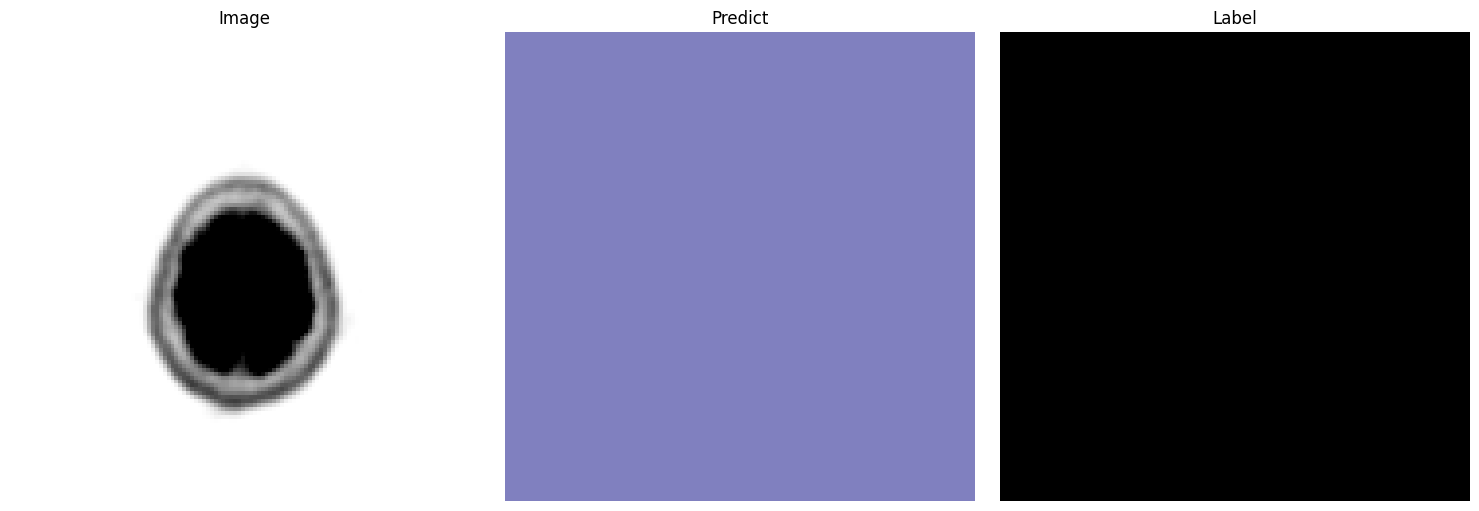

Image: 24


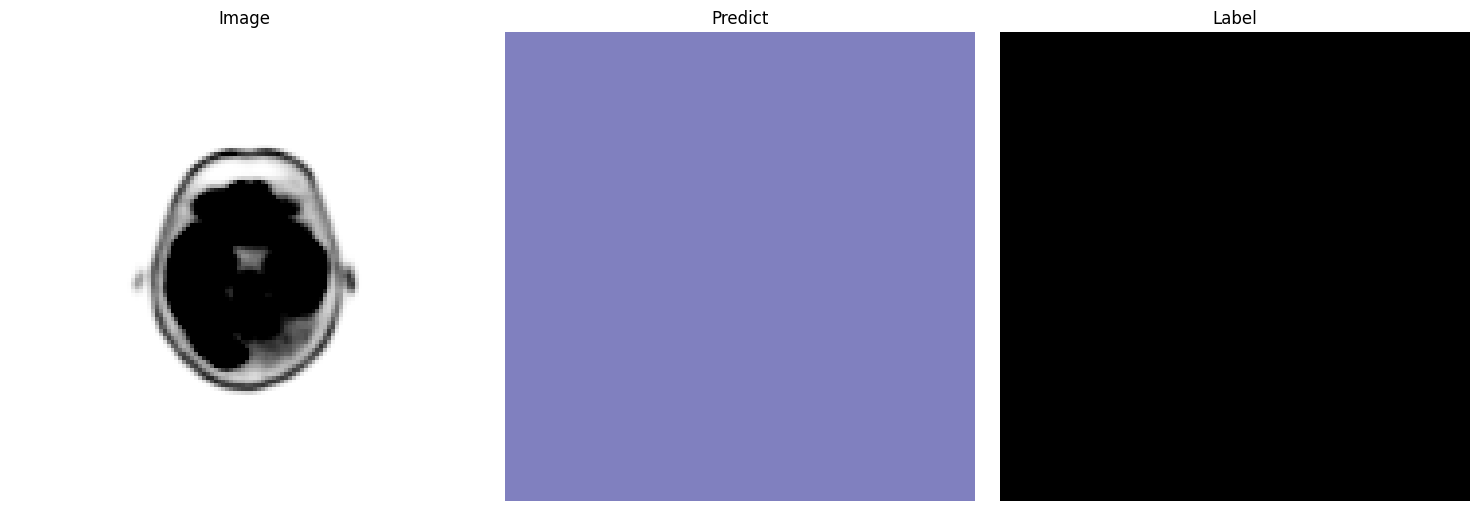

Image: 25


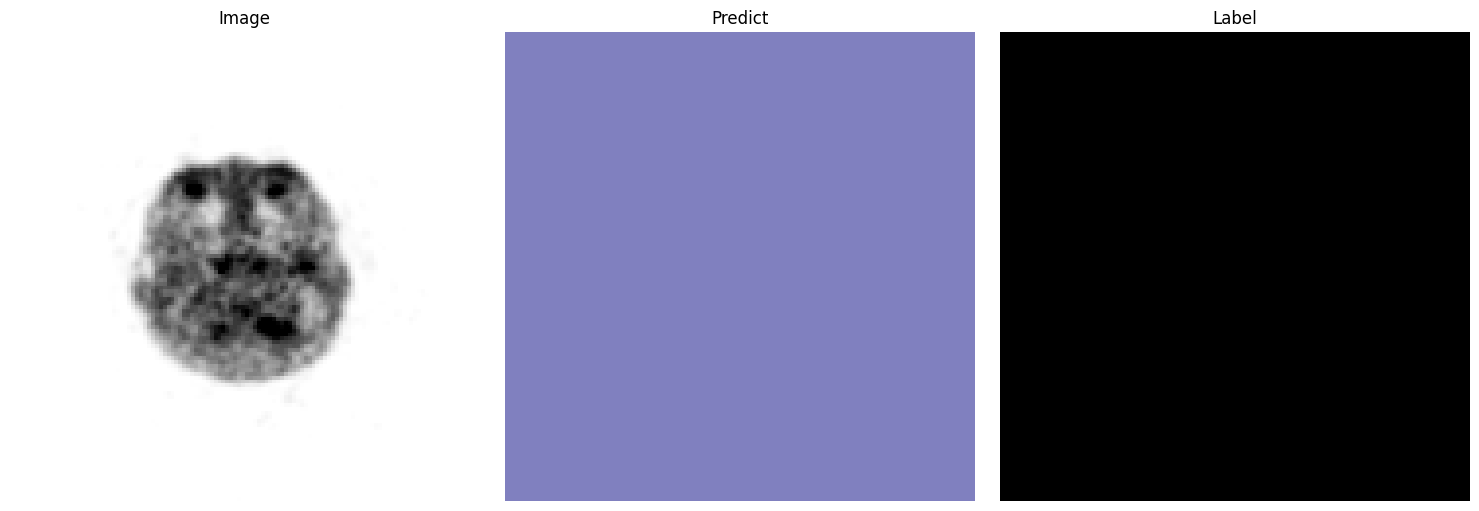

Image: 26


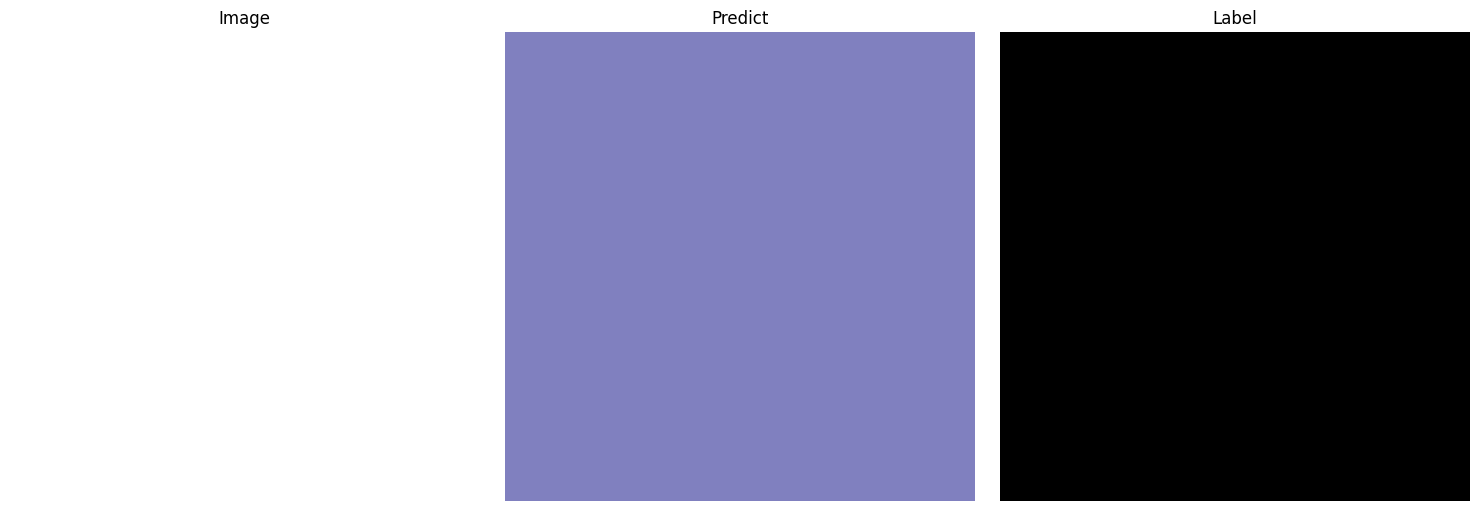

Image: 27


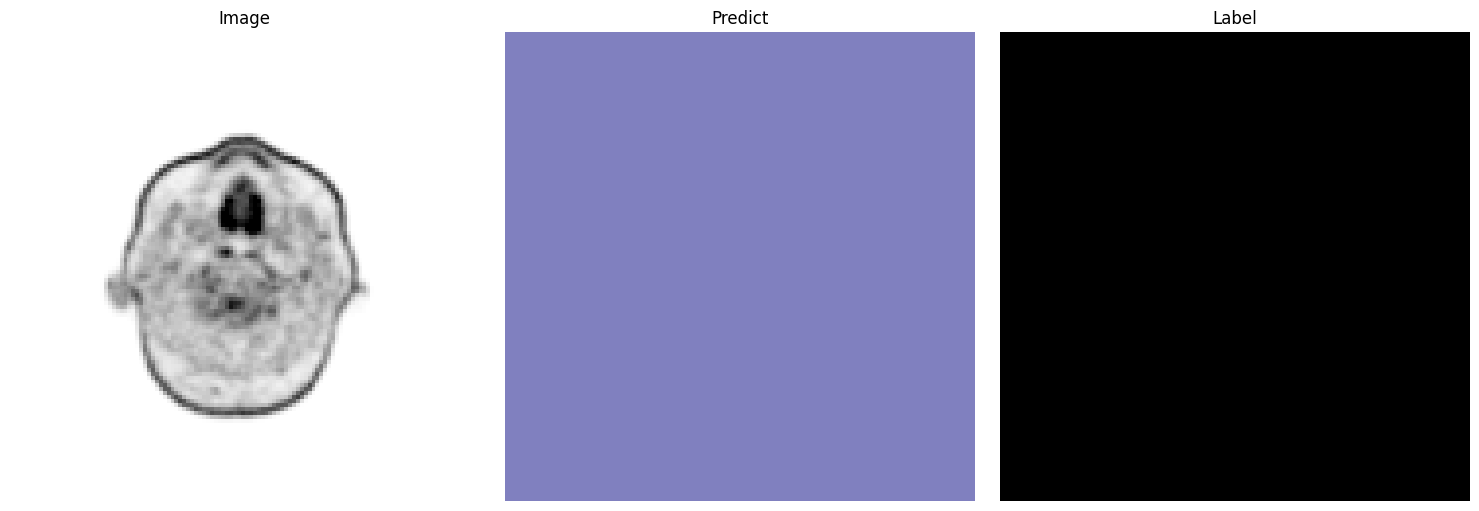

Image: 28


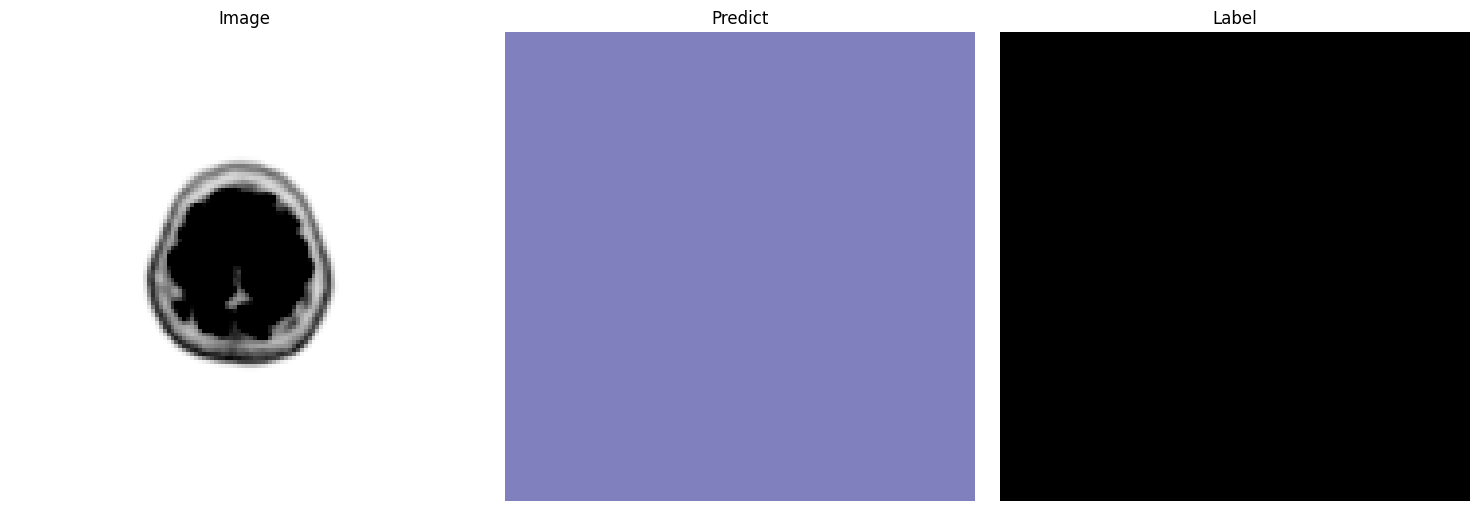

Image: 29


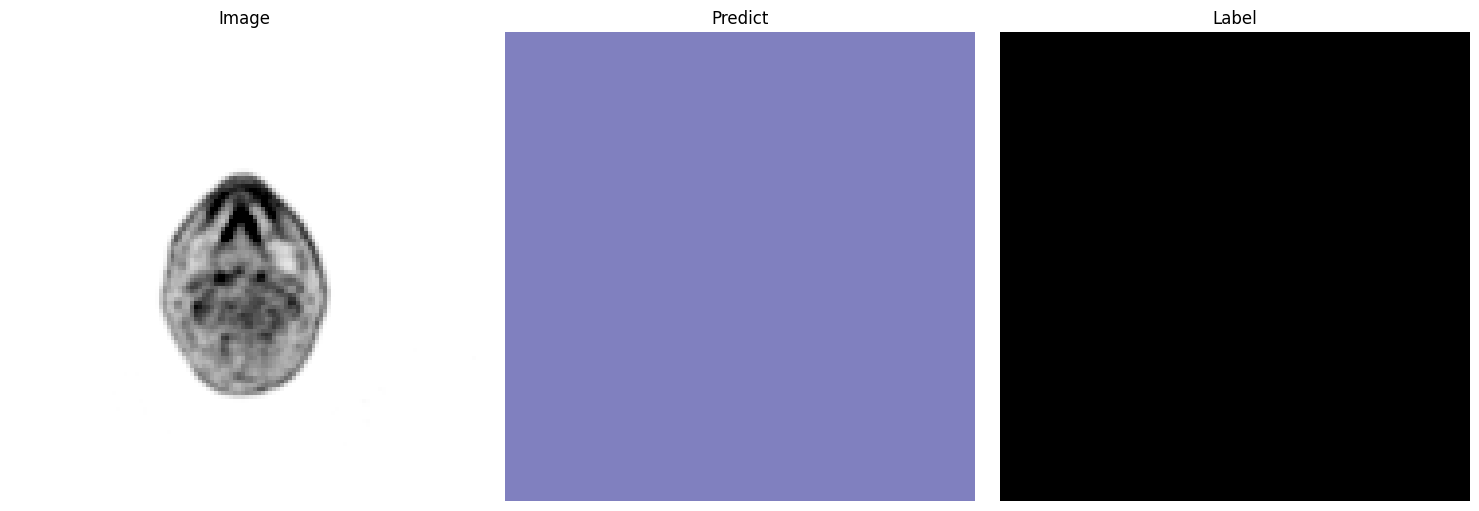

Image: 30


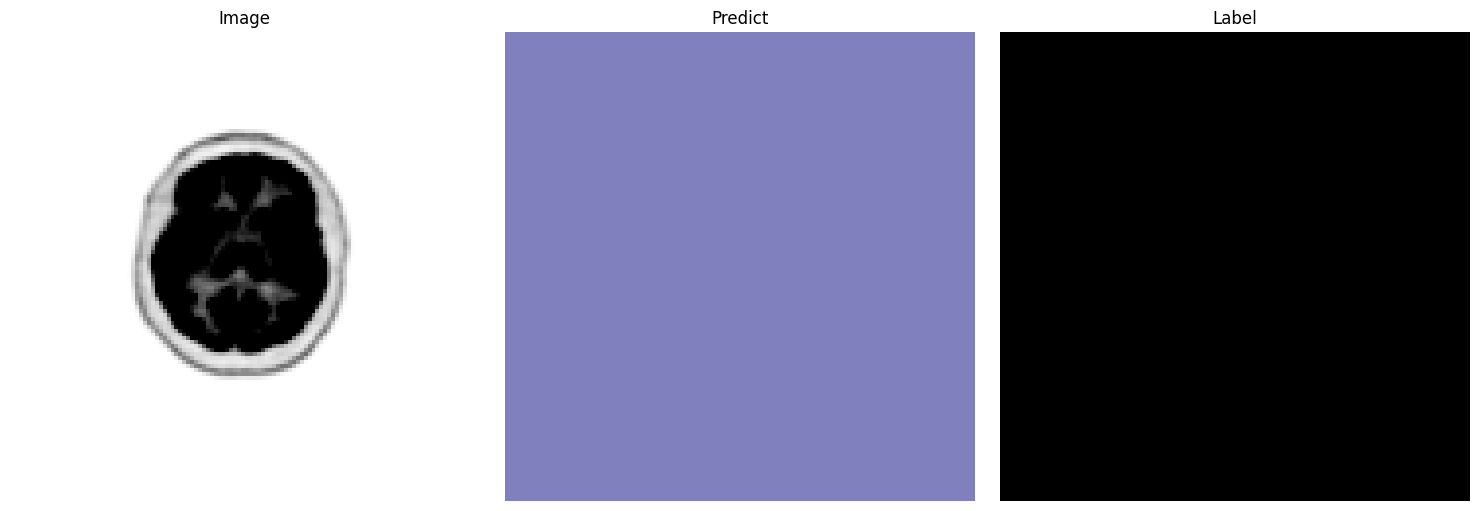

Image: 31


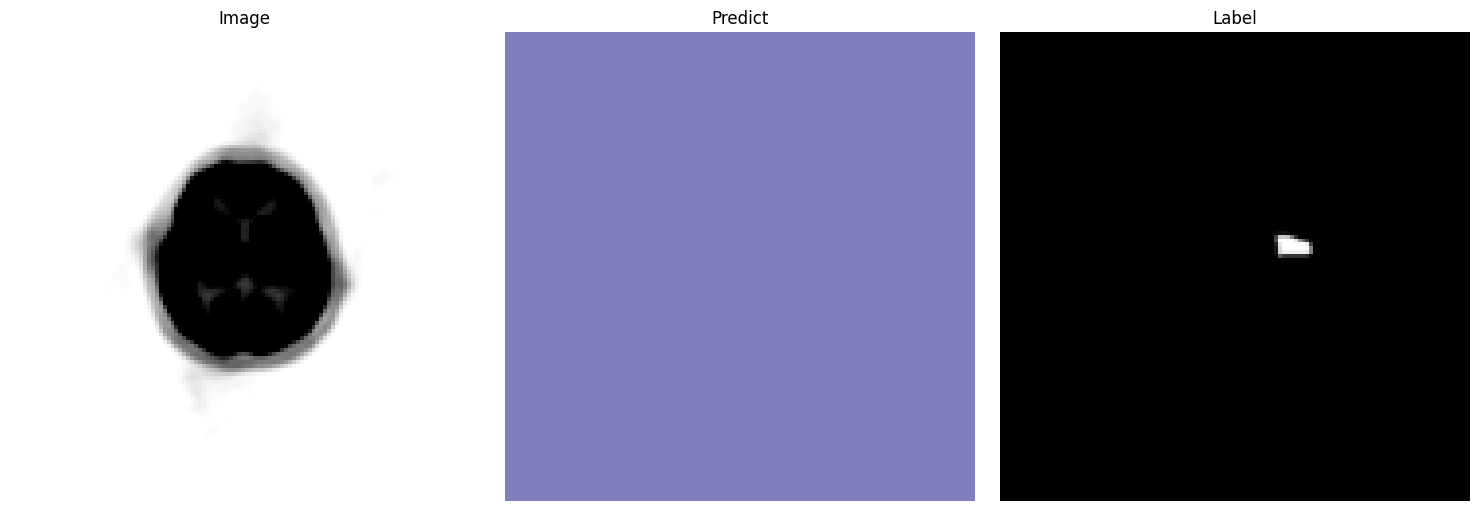

Image: 32


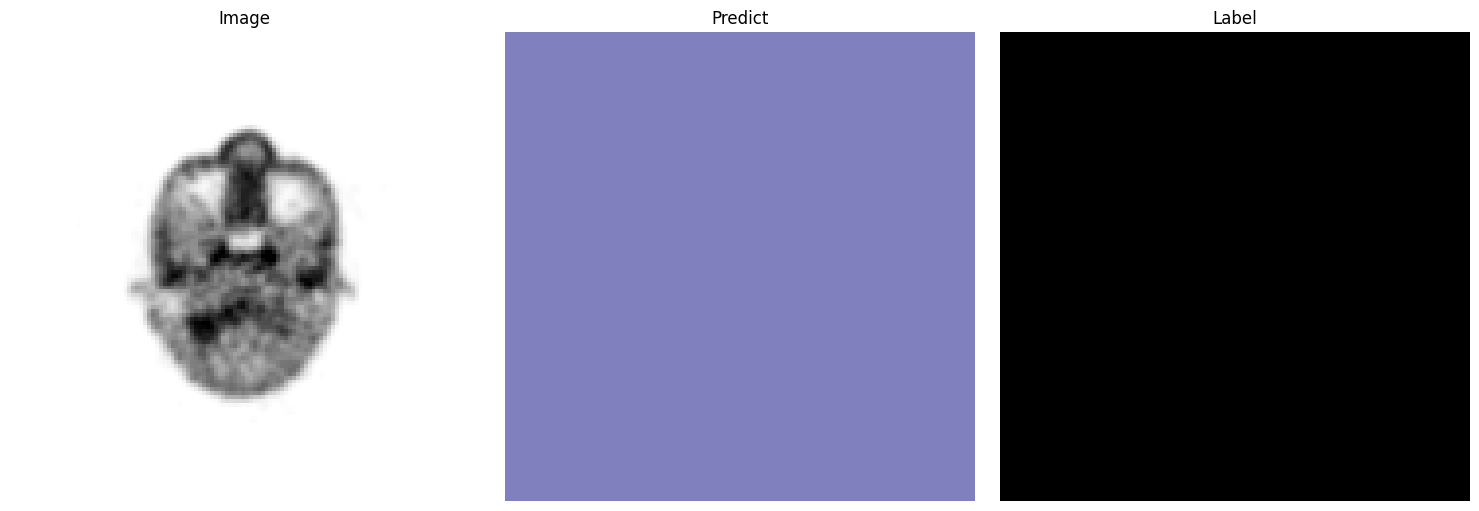

In [21]:
import itertools

# Display 1 batch (32 images)
N = 1

# Set the model to evaluation mode
Net.eval()

# Iterate over the data loader
for images, labels in itertools.islice(valloader, N):
    images = images.to(device)

    # Perform the inference
    with torch.no_grad():
        outputs = Net(images)

        # Get the predicted segmentation mask from the outputs dictionary
        predictions = outputs['out']

    # Visualize or analyze the predictions for each image
    for i in range(len(images)):
    
        # Get the i-th image and its corresponding prediction
        print(f"Image: {i + 1}")
        image = images[i].cpu().numpy()[0]
        label = labels[i].cpu().numpy()[0]
        prediction = predictions[i].argmax(dim=0).cpu().numpy() 
    
        # Create subplot for visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Visualize the segmentation prediction
        axes[0].imshow(image, cmap='gray', vmin=0, vmax=1)
        axes[0].set_title("Image")
        axes[0].axis('off')

        axes[1].imshow(prediction, alpha=0.5, cmap='jet', vmin=0, vmax=2)
        axes[1].set_title("Predict")
        axes[1].axis('off')

        axes[2].imshow(label, cmap='gray', vmin=0, vmax=1)
        axes[2].set_title("Label")
        axes[2].axis('off')

        fig.tight_layout()
        plt.show()